In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras import layers
from tensorflow.keras import callbacks

In [3]:
dirpath='colon_images'
IMG_SIZE=180
BATCH_SIZE=32
CHANNELS=3
EPOCHS=20
INPUT_SHAPE = (BATCH_SIZE, IMG_SIZE, IMG_SIZE, CHANNELS)
N_CLASSES = 2

In [6]:
dataset= tf.keras.preprocessing.image_dataset_from_directory(
    dirpath,
    seed=123,
    shuffle=True,
    image_size=(IMG_SIZE,IMG_SIZE),
    batch_size=BATCH_SIZE
)

Found 10000 files belonging to 2 classes.


In [7]:
classes_name=dataset.class_names
classes_name

['colon_aca', 'colon_n']

In [8]:
for batch_img,batch_label in dataset.take(1):
    print(batch_img.shape)
    print(batch_label.numpy())

(32, 180, 180, 3)
[1 0 0 0 0 1 1 0 1 0 0 0 0 0 0 1 1 1 0 1 0 1 1 0 0 0 0 1 1 1 0 1]


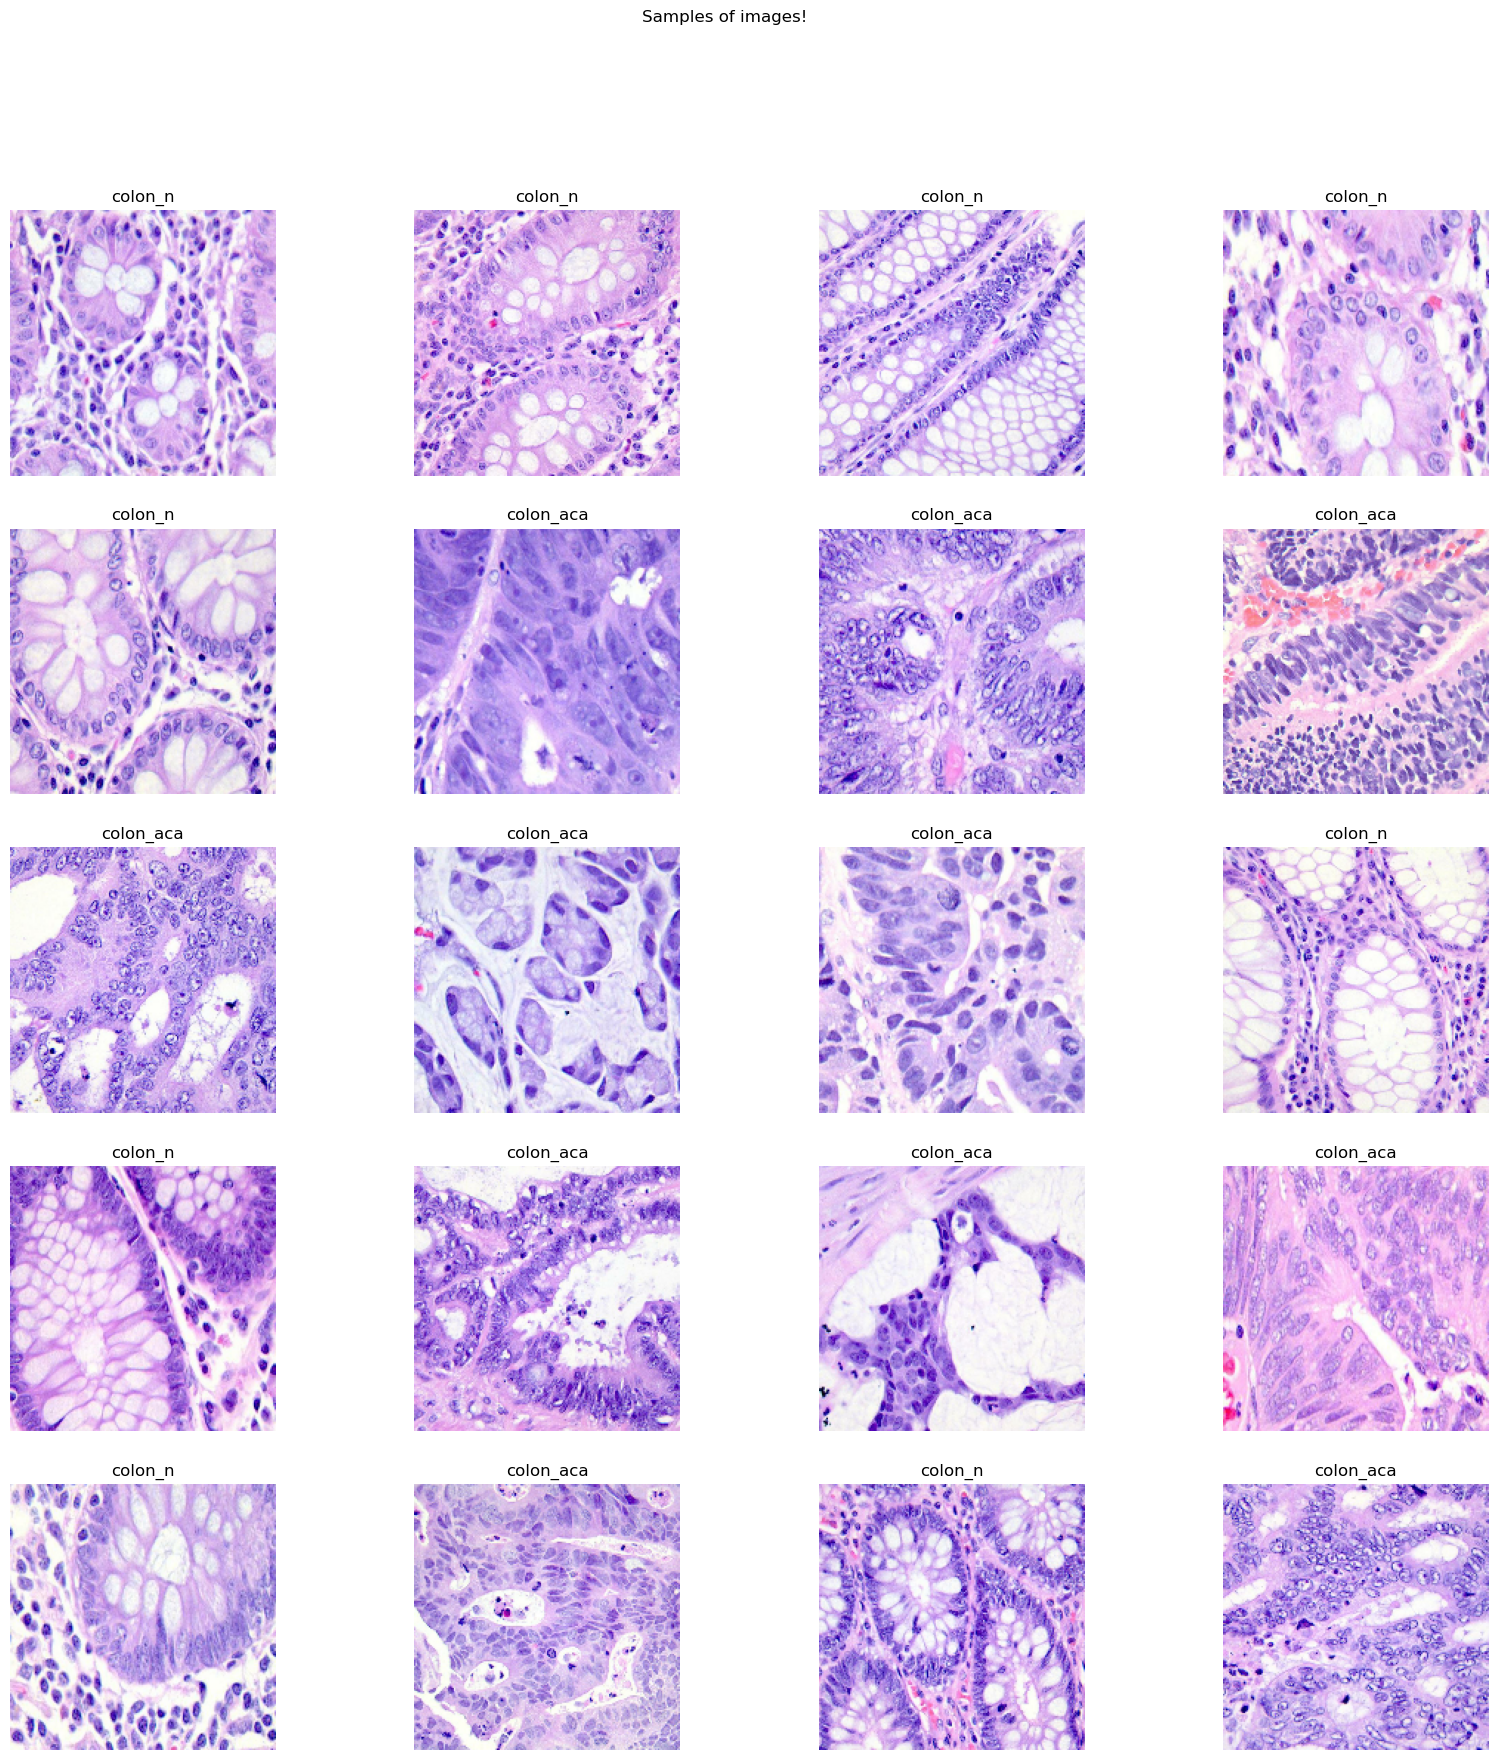

In [9]:
plt.figure(figsize=(20, 20))
plt.suptitle('Samples of images!')
for batch_img,batch_label in dataset.take(1):
   for i in range(20):
      ax=plt.subplot(5,4,i+1)
      plt.title(classes_name[batch_label[i]])
      plt.imshow(batch_img[i].numpy().astype('uint8'))
      plt.axis('off')

In [15]:
def split_train_val_test(dataset,train_split=0.8,test_split=0.1,val_split=0.1,shuffle=True,shuffle_size=2000):
   assert(train_split+val_split+test_split)==1


   if shuffle:
        dataset = dataset.shuffle(shuffle_size, seed=12)
    #set size of train,test and val
   train_size=int(train_split*len(dataset))
   val_size=int(val_split*len(dataset))
   test_size=int(test_split*len(dataset))


   train_ds=dataset.take(train_size)
   val_ds=dataset.skip(train_size).take(val_size)
   test_ds=dataset.skip(train_size+val_size).take(test_size)


   return train_ds,val_ds,test_ds

In [16]:
train,val,test=split_train_val_test(dataset)


In [17]:
print(len(train))
print(len(test))
print(len(val))

250
31
31


In [18]:
# Cache, shuffle, and prefetch the datasets with a reduced buffer size
train_ds = train.cache().shuffle(500).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val.cache().shuffle(500).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test.cache().shuffle(500).prefetch(buffer_size=tf.data.AUTOTUNE)


In [19]:
resize_scaling=tf.keras.Sequential([
    layers.Resizing(IMG_SIZE,IMG_SIZE),
    layers.Rescaling(1./255)
])

# Building the Model

In [20]:
cnn_model=tf.keras.models.Sequential([
    resize_scaling,
    layers.Conv2D(32, kernel_size = (3,3),padding='same',activation='relu', input_shape=INPUT_SHAPE),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), padding='same',activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(N_CLASSES,activation='softmax')

])

In [21]:
cnn_model.build(input_shape=INPUT_SHAPE)


In [22]:
cnn_model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 180, 180, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 180, 180, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 90, 90, 32)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 90, 90, 64)          18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 45, 45, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 43, 43, 64)         

In [26]:
tensorboard = tf.keras.callbacks.TensorBoard(log_dir = 'logs')
checkpoint =tf.keras.callbacks.ModelCheckpoint("colon.keras",monitor="val_loss",save_best_only=True,mode="auto",verbose=1)
reduce_lr =tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min',restore_best_weights=True)

In [27]:
cnn_model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
history=cnn_model.fit(train_ds,validation_data=val_ds,epochs=10,batch_size=BATCH_SIZE,verbose=1,
             callbacks=[tensorboard,checkpoint,early_stopping,reduce_lr])

Epoch 1/10
250/250 [==============================] - ETA: 0s - loss: 0.0928 - accuracy: 0.9669
Epoch 1: val_loss improved from inf to 0.97809, saving model to colon.keras
250/250 [==============================] - 216s 862ms/step - loss: 0.0928 - accuracy: 0.9669 - val_loss: 0.9781 - val_accuracy: 0.7419 - lr: 0.0010
Epoch 2/10
250/250 [==============================] - ETA: 0s - loss: 0.0639 - accuracy: 0.9765
Epoch 2: val_loss did not improve from 0.97809
250/250 [==============================] - 177s 710ms/step - loss: 0.0639 - accuracy: 0.9765 - val_loss: 42.5459 - val_accuracy: 0.4909 - lr: 0.0010
Epoch 3/10
250/250 [==============================] - ETA: 0s - loss: 0.0307 - accuracy: 0.9897
Epoch 3: val_loss did not improve from 0.97809

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
250/250 [==============================] - 246s 983ms/step - loss: 0.0307 - accuracy: 0.9897 - val_loss: 7.5516 - val_accuracy: 0.5141 - lr: 0.0010
Epoch 4/10
250/250 [

# Model Performance

In [ ]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'skyblue', label= 'Training loss')
plt.plot(Epochs, val_loss, 'purple', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'skyblue', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'purple', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

# Confusion Matrix

In [ ]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'skyblue', label= 'Training loss')
plt.plot(Epochs, val_loss, 'purple', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'skyblue', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'purple', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [ ]:
display_conf_matrix()


In [ ]:
def get_predicitions():
    all_true_labels = []
    all_predicted_labels = []
    all_images=[]

    classes_name=dataset.class_names
    #get all the predictions and true labels
    for image_batch, label_batch in test_ds:
            # Make predictions on the batch
            predictions = cnn_model.predict(image_batch)

            # Convert predictions to class indices
            predicted_labels = np.argmax(predictions, axis=1)

            #append matrix of images
            all_images.extend(image_batch)
            true_labels = label_batch

            all_true_labels.extend(true_labels)
            all_predicted_labels.extend(predicted_labels)

            print(len(all_true_labels))
    #plot the predictions
    index=0
    plt.figure(figsize=(20, 20))
    plt.suptitle('Prediction of Colon Cancer!')

    for i in range(30,61):
        if index<15:
            ax=plt.subplot(5,3,index+1)
            color = 'green' if all_true_labels[i] == all_predicted_labels[i] else 'red'
            plt.title(f'true_class:{classes_name[all_true_labels[i]]}\npredicted_class:{classes_name[all_predicted_labels[i]]}',color=color)
            plt.imshow(np.array(all_images[i]).astype('uint8'))
            plt.axis('off')
            index+=1
        else:
            index=0

In [ ]:
get_predicitions()
